![](imagenes/UC_FMRI.jpg)

---

***Andrés Eduardo Aracena Rangel***

---


&nbsp;

Con referencia a:

 - [nipype beginner's guide de Michael Notter](https://miykael.github.io/nipype-beginner-s-guide/index.html)
 
&nbsp;
 
Imagenes de fMRI extraidas de OpenNuero:
 
 - [ds002422](https://openneuro.org/datasets/ds002422/versions/1.1.0)

# Recon-all de Freesurfer

*recon-all* es el proceso de reconstrucción cortical de FreeSurfer que crea automáticamente una parcela de regiones corticales y una segmentación de regiones subcorticales . Puede encontrar una descripción más detallada sobre el proceso *recon-all* en la página de [inicio oficial](https://surfer.nmr.mgh.harvard.edu/fswiki/recon-all) .

Es recomendable ejecutar el procceso *recon-all* de FreeSurfer en las exploraciones anatómicas de los sujetos, debido a que muchos de los otros algoritmos de FreeSurfer requieren la salida de recon-all. 

El único aspecto negativo es que *recon-all* lleva bastante tiempo procesar un solo tema. En mi caso, presento las caracteristicas del CPU con el que se ejecuto este notebook (el cual puede verifiricar con el comendo *lscpu* en tu teminal linux):


<img src = 'imagenes/comand_lscpu.png' width = '550'>


Mis tiempos medios obtenidos fueron de:

 - 1 Sujeto $\Longrightarrow$ $\approx$ $5.1\;h$
 
<img src = 'imagenes/tiempo_ejecucion.png' width = '350'>

 - 2 Sujetos $\Longrightarrow$ $\approx$ $6.5\;h$

<img src = 'imagenes/tiempo_ejecucion_2.png' width = '345'>

 - 6 Sujetos $\Longrightarrow$ $\approx$ $11.6\;h$
 
<img src = 'imagenes/tiempo_ejecucion_3.png' width = '350'>


Se debe conocer la ruta de los archivos que deseamos procesar, en nuestro caso:

    sujeto 1   -->  /home/aracena/thesis_practica/data/ds002422/sub-01/anat/sub-01_T1w.nii
    sujeto 2   -->  /home/aracena/thesis_practica/data/ds002422/sub-02/anat/sub-02_T1w.nii
    .
    .
    .
    sujeto 46  -->  /home/aracena/thesis_practica/data/ds002422/sub-46/anat/sub-46_T1w.nii 
    
Vemos que los archivos solo tiene un parametro dinámico entre sujetos:

    subject_id: ['sub-01', 'sub-02', . . . , 'sub-46']
    

Lo que significa que podemos reescribir las rutas de la siguiente manera:

    /home/aracena/thesis_practica/data/ds002422/[subject_id]/anat/[subject_id]_T1w.nii   
    



## Importamos librerias

In [1]:
import time # medir el tiempo de ejecución de nuestros programas
start = time.process_time()
inicio = time.time()

In [2]:
import os # El módulo os nos permite acceder a funcionalidades dependientes del Sistema Operativo
from os.path import join as opj # Este método concatena varios componentes de ruta con exactamente un separador de directorio(‘/’)
from nipype.interfaces.utility import IdentityInterface # La clase de interfaz básica genera asignaciones de identidad
from nipype.interfaces.freesurfer import ReconAll # clase ReconAll de Freesurfer: generara superficies y parcelaciones de datos estructurales
                                                    #a partir de imágenes anatómicas de un sujeto.
from nipype.pipeline.engine import Workflow, Node # Worflow: El propósito de los flujos de trabajo es guiar la ejecución secuencial de Nodos
                                                    #Node: objeto que representa una determinada función de interfaz

## Definimos Parametros

In [3]:
# Ruta del directorio del proyecto
experiment_dir = '/home/aracena/thesis_practica' 

# Ruta de la carpeta donde se encuentran las imagenes
data_dir = opj(experiment_dir, 'data', 'ds002422')

# Ruta de la carpeta freesurfer donde se guaradaran los resultados de recon-all
fs_folder = opj(experiment_dir, 'tips_nibabel','3_recon-all_freesurfer','output','freesurfer')

# Lista de indetificación de sujetos
subject_list = ['sub-05', 'sub-06','sub-07', 'sub-08','sub-09', 'sub-10'] 

# Nombre de la imagen pondera en T1 que sera procesada
T1_identifier = 'T1w.nii' 

# Crear la carpeta de salida: FreeSurfer solo se puede ejecutar si esta carpeta existe
os.system('mkdir -p %s'%fs_folder)

0

## Definimos Funciones

In [4]:
# Esta función devuelve para cada sujeto la ruta a struct.nii.gz
def pathfinder(subject, foldername, filename):
    from os.path import join as opj
    struct_path = opj(foldername, subject, 'anat', subject+'_'+filename)
    return struct_path

## Creamos Nodos

In [5]:
# Este nodo genera asignaciones de identidad
infosource = Node(IdentityInterface(fields=['subject_id']),
                  name="infosource")
infosource.iterables = ('subject_id', subject_list)

# Este nodo representa el comando recon-all
reconall = Node(ReconAll(directive='all',
                         #flags='-nuintensitycor-3T',
                         subjects_dir=fs_folder),
                name="reconall")

## Especificamos el flujos de trabajo

In [6]:
# Creamos la canalización que ejecuta el comando recon-all
reconflow = Workflow(name="reconflow")
reconflow.base_dir = opj(experiment_dir,'tips_nibabel','3_recon-all_freesurfer','output', 'workingdir_reconflow')

## Conectamos nodos

In [7]:
# Esta sección conecta todos los nodos de la tubería entre sí.
reconflow.connect([(infosource, reconall, [('subject_id', 'subject_id')]),
                   (infosource, reconall, [(('subject_id', pathfinder,
                                             data_dir, T1_identifier),
                                            'T1_files')]),
                   ])

## Visualizamos el flujo de trabajo

211228-13:30:09,80 nipype.workflow INFO:
	 Generated workflow graph: /home/aracena/thesis_practica/tips_nibabel/3_recon-all_freesurfer/output/workingdir_reconflow/reconflow/workflow_graph.png (graph2use=hierarchical, simple_form=True).


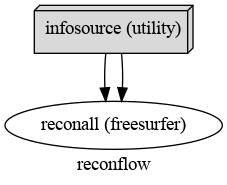

In [8]:
reconflow.write_graph('workflow_graph.dot')
from IPython.display import Image
Image(filename=experiment_dir+
      '/tips_nibabel/3_recon-all_freesurfer/output/workingdir_reconflow/' +
      'reconflow/workflow_graph.png')

211228-13:30:10,635 nipype.workflow INFO:
	 Generated workflow graph: /home/aracena/thesis_practica/tips_nibabel/3_recon-all_freesurfer/output/workingdir_reconflow/reconflow/graph.png (graph2use=flat, simple_form=True).


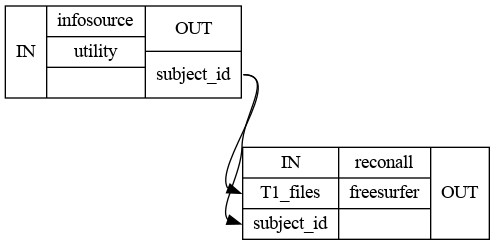

In [9]:
# Otra visualización del flujo de trabajo
reconflow.write_graph(graph2use='flat')
Image(filename=experiment_dir+
      '/tips_nibabel/3_recon-all_freesurfer/output/workingdir_reconflow/' +
      'reconflow/graph_detailed.png')

## Ejecutamos el Flujo de trabajo

In [10]:
# Este comando ejecuta la canalización recon-all en paralelo (usando 8 núcleos)
reconflow.run('MultiProc', plugin_args={'n_procs': 8})

211228-13:30:10,966 nipype.workflow INFO:
	 Workflow reconflow settings: ['check', 'execution', 'logging', 'monitoring']
211228-13:30:11,114 nipype.workflow INFO:
	 Running in parallel.
211228-13:30:11,120 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 13.99/13.99, Free processors: 8/8.
211228-13:30:11,188 nipype.workflow INFO:
	 [Node] Setting-up "reconflow.reconall" in "/opt/home/aracena/thesis_practica/tips_nibabel/3_recon-all_freesurfer/output/workingdir_reconflow/reconflow/_subject_id_sub-10/reconall".
211228-13:30:11,199 nipype.workflow INFO:
	 [Node] Executing "reconall" <nipype.interfaces.freesurfer.preprocess.ReconAll>
211228-13:30:11,199 nipype.workflow INFO:
	 [Node] Setting-up "reconflow.reconall" in "/opt/home/aracena/thesis_practica/tips_nibabel/3_recon-all_freesurfer/output/workingdir_reconflow/reconflow/_subject_id_sub-09/reconall".
211228-13:30:11,209 nipype.workflow INFO:
	 [Node] Executing "reconall" <nipype.interfaces.freesu

## Visualizamos el tiempo de ejecución

In [11]:
fin = time.time()
end = time.process_time()
tiempo = fin - inicio
tiempo2 = end - start

print('-----------------------------\n', 
      'tiempo de ejecución\n', tiempo, 'seg\n',
     '-----------------------------\n')
print('---------------------------------------\n', 
      'tiempo de ejecución del sistema y CPU\n', tiempo2, 'seg\n',
     '---------------------------------------\n')

-----------------------------
 tiempo de ejecución
 41604.372452259064 seg
 -----------------------------

---------------------------------------
 tiempo de ejecución del sistema y CPU
 2589.701964602 seg
 ---------------------------------------



In [12]:
# eliminar todos los archivos temporales almacenados en la carpeta 'workingdir_reconflow'
os.system('rm -rf %s'%reconflow.base_dir)

0